<a href="https://colab.research.google.com/github/data-science-and-machine-learning/CNN-MNIST/blob/master/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Credits: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py


from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def plt_dynamic(x, vy, ty, colors=['b']):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.set_ylabel('Categorical Crossentropy Loss')
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 20s 341us/step - loss: 0.2944 - acc: 0.9102 - val_loss: 0.0642 - val_acc: 0.9801
Epoch 2/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0927 - acc: 0.9719 - val_loss: 0.0442 - val_acc: 0.9852
Epoch 3/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0700 - acc: 0.9791 - val_loss: 0.0356 - val_acc: 0.9879
Epoch 4/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0554 - acc: 0.9833 - val_loss: 0.0293 - val_acc: 0.9904
Epoch 5/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0477 - acc: 0.9854 - val_loss: 0.0301 - val_acc: 0.9900
Epoch 6/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0434 - acc: 0.9868 - val_loss: 0.0307 - val_acc: 0.9906
Epoch 7/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0398 - acc: 0.9880 - val_loss: 0.

## Model 1 : Hyperparameter tuning on kernel size, applying cross validation and comparing results

In [0]:
def conv_model(kernel):
  model_1 = Sequential()
  #Layer 1 [ReLU]
  model_1.add(Conv2D(32, kernel_size=kernel,
                  activation='relu',
                  input_shape=input_shape))

  #Layer 2 [ReLU]
  model_1.add(Conv2D(64, kernel, activation='relu'))
  model_1.add(MaxPooling2D(pool_size=(2, 2)))
  model_1.add(Dropout(0.25))

  #Layer 3 [ReLU]
  model_1.add(Flatten())
  model_1.add(Dense(128, activation='relu'))
  model_1.add(Dropout(0.5))

  #Layer 4 [Softmax]
  model_1.add(Dense(num_classes, activation='softmax'))

  model_1.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return model_1


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel= [(3,3), (5,5), (7,7)]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_kernel_hptuning= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 51.6min finished


In [0]:
print("Best: %f using %s" % (grid_result_kernel_hptuning.best_score_, grid_result_kernel_hptuning.best_params_))
print("Best estimator: ", grid_result_kernel_hptuning.best_estimator_)

means_test = grid_result_kernel_hptuning.cv_results_['mean_test_score']
means_train = grid_result_kernel_hptuning.cv_results_['mean_train_score']
stds_test = grid_result_kernel_hptuning.cv_results_['std_test_score']
stds_train = grid_result_kernel_hptuning.cv_results_['std_train_score']
params = grid_result_kernel_hptuning.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991367 using {'batch_size': 64, 'kernel': (7, 7)}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5a831fde80>
0.987983 0.998283 (0.000383) with: {'batch_size': 32, 'kernel': (3, 3)}
0.989783 0.999250 (0.000250) with: {'batch_size': 32, 'kernel': (5, 5)}
0.990533 0.999533 (0.001067) with: {'batch_size': 32, 'kernel': (7, 7)}
0.988783 0.999150 (0.000383) with: {'batch_size': 64, 'kernel': (3, 3)}
0.990667 0.999333 (0.000300) with: {'batch_size': 64, 'kernel': (5, 5)}
0.991367 0.999633 (0.000100) with: {'batch_size': 64, 'kernel': (7, 7)}
0.989117 0.999317 (0.000783) with: {'batch_size': 128, 'kernel': (3, 3)}
0.990117 0.999167 (0.000050) with: {'batch_size': 128, 'kernel': (5, 5)}
0.990700 0.999300 (0.000800) with: {'batch_size': 128, 'kernel': (7, 7)}


In [0]:
import pickle
with open('grid_result_kernel_hptuning_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_result_kernel_hptuning.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_kernel_hptuning.pickle drive/My\ Drive/CNN_models/

cp: cannot stat 'grid_result_kernel_hptuning.pickle': No such file or directory


9


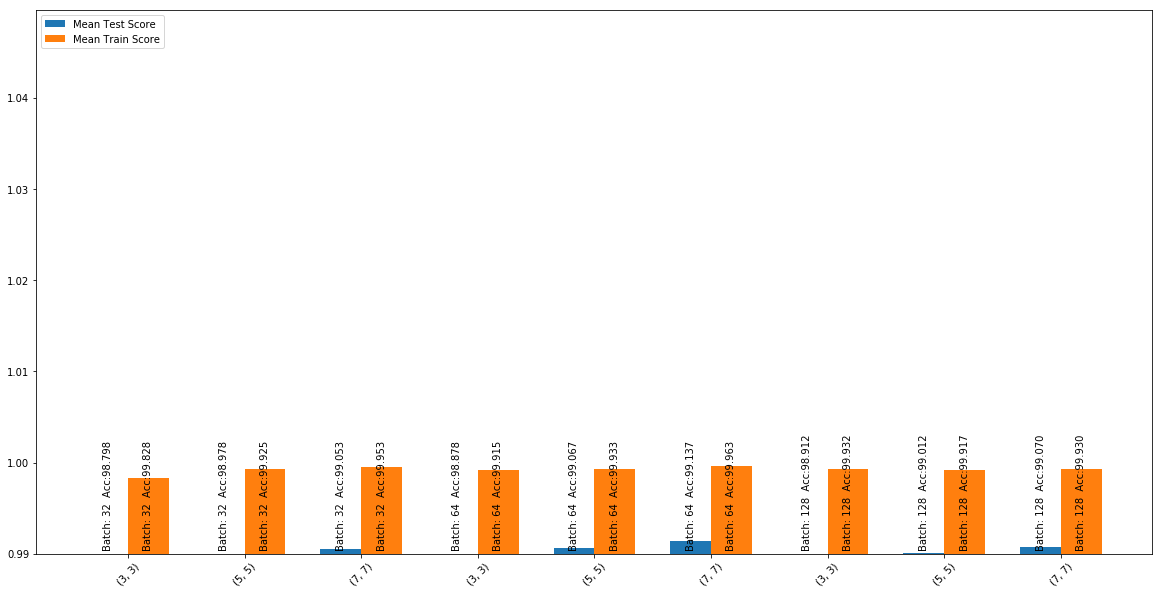

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

It can be observed (7, 7) kernel improved test result and best among all with 64 batch size

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 39s 654us/step - loss: 0.1753 - acc: 0.9466 - val_loss: 0.0418 - val_acc: 0.9860
Epoch 2/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0688 - acc: 0.9798 - val_loss: 0.0273 - val_acc: 0.9914
Epoch 3/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0508 - acc: 0.9850 - val_loss: 0.0259 - val_acc: 0.9916
Epoch 4/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0413 - acc: 0.9879 - val_loss: 0.0275 - val_acc: 0.9913
Epoch 5/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0376 - acc: 0.9889 - val_loss: 0.0238 - val_acc: 0.9926
Epoch 6/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0345 - acc: 0.9893 - val_loss: 0.0237 - val_acc: 0.9930
Epoch 7/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0307 - acc: 0.9906 - val_loss: 0.

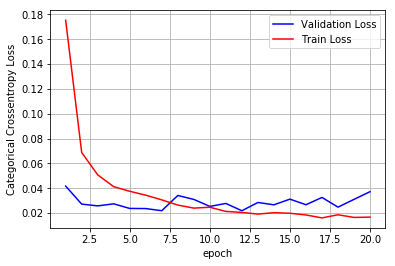

In [0]:
# best model
model= conv_model((7, 7))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 2 : Hyperparameter tuning with added Batch normalization, applying cross validation and comparing results

In [0]:
# Adding batch normalization to the model
def conv_model(kernel):
  Model_2= Sequential()
  #Layer 1 [ReLU]
  Model_2.add(Conv2D(32, kernel_size=kernel,
                  activation='relu',
                  input_shape=input_shape))
  Model_2.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_2.add(Conv2D(64, kernel, activation='relu'))
  Model_2.add(BatchNormalization())
  Model_2.add(MaxPooling2D(pool_size=(2, 2)))
  Model_2.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_2.add(Flatten())
  Model_2.add(Dense(128, activation='relu'))
  Model_2.add(BatchNormalization())
  Model_2.add(Dropout(0.5))

  #Layer 4 [Softmax]
  Model_2.add(Dense(num_classes, activation='softmax'))

  Model_2.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_2


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel= [(3,3), (5,5), (7,7)]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_batchnorm= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 70.2min finished


In [0]:
print("Best: %f using %s" % (grid_result_batchnorm.best_score_, grid_result_batchnorm.best_params_))
print("Best estimator: ", grid_result_batchnorm.best_estimator_)

means_test = grid_result_batchnorm.cv_results_['mean_test_score']
means_train = grid_result_batchnorm.cv_results_['mean_train_score']
stds_test = grid_result_batchnorm.cv_results_['std_test_score']
stds_train = grid_result_batchnorm.cv_results_['std_train_score']
params = grid_result_batchnorm.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991050 using {'batch_size': 128, 'kernel': (7, 7)}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5a7387f978>
0.989033 0.999850 (0.000200) with: {'batch_size': 32, 'kernel': (3, 3)}
0.990767 0.999917 (0.000300) with: {'batch_size': 32, 'kernel': (5, 5)}
0.990183 0.999733 (0.001517) with: {'batch_size': 32, 'kernel': (7, 7)}
0.988533 0.999900 (0.000633) with: {'batch_size': 64, 'kernel': (3, 3)}
0.991000 0.999917 (0.000067) with: {'batch_size': 64, 'kernel': (5, 5)}
0.990750 0.999833 (0.000150) with: {'batch_size': 64, 'kernel': (7, 7)}
0.987950 0.999933 (0.000317) with: {'batch_size': 128, 'kernel': (3, 3)}
0.989833 0.999767 (0.000167) with: {'batch_size': 128, 'kernel': (5, 5)}
0.991050 0.999850 (0.000550) with: {'batch_size': 128, 'kernel': (7, 7)}


In [0]:
import pickle
with open('grid_result_batchnorm_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_result_batchnorm.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_batchnorm.pickle drive/My\ Drive/CNN_models/

cp: cannot stat 'grid_result_batchnorm.pickle': No such file or directory


9


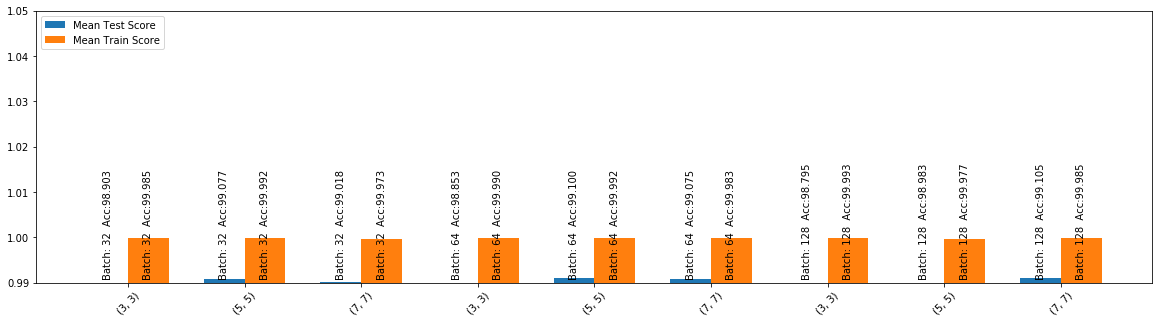

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,5))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

After applying batch normalization we can see 2 more models predicting more than 99% accuracy, also the best accuracy is 99.14 which is an improvement. Hence batch normalization is useful.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 52s 867us/step - loss: 0.1491 - acc: 0.9549 - val_loss: 0.0414 - val_acc: 0.9860
Epoch 2/20
60000/60000 [==============================] - 34s 572us/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.0257 - val_acc: 0.9914
Epoch 3/20
60000/60000 [==============================] - 35s 577us/step - loss: 0.0491 - acc: 0.9852 - val_loss: 0.0343 - val_acc: 0.9885
Epoch 4/20
60000/60000 [==============================] - 34s 572us/step - loss: 0.0447 - acc: 0.9867 - val_loss: 0.0232 - val_acc: 0.9918
Epoch 5/20
60000/60000 [==============================] - 34s 571us/step - loss: 0.0368 - acc: 0.9887 - val_loss: 0.0295 - val_acc: 0.9902
Epoch 6/20
60000/60000 [==============================] - 34s 570us/step - loss: 0.0306 - acc: 0.9908 - val_loss: 0.0168 - val_acc: 0.9945
Epoch 7/20
60000/60000 [==============================] - 34s 573us/step - loss: 0.0282 - acc: 0.9913 - val_loss: 0.

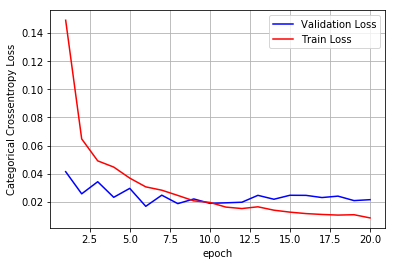

In [0]:
# best model
model= conv_model((7, 7))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 3 : Hyperparameter tuning with varying kernels, applying cross validation and comparing results

In [0]:
# Adding batch normalization to the model
def conv_model_varying_kernel(kernel_n):
  Model_3 = Sequential()
  #Layer 1 [ReLU]
  Model_3.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape))
  Model_3.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_3.add(Conv2D(64, (kernel_n+2, kernel_n+2), activation='relu'))
  Model_3.add(BatchNormalization())
  Model_3.add(MaxPooling2D(pool_size=(2, 2)))
  Model_3.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_3.add(Flatten())
  Model_3.add(Dense(128, activation='relu'))
  Model_3.add(BatchNormalization())
  Model_3.add(Dropout(0.5))

  #Layer 4 [Softmax]
  Model_3.add(Dense(num_classes, activation='softmax'))

  Model_3.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_3


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5, 7]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_varyingkernel= grid.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0819 02:19:09.553673 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 02:19:09.599063 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 02:19:09.605800 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Fitting 2 folds for each of 9 candidates, totalling 18 fits


W0819 02:19:09.654608 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 02:19:09.655855 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0819 02:19:12.576645 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0819 02:19:12.762494 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 02:19:12.772203 14002334

In [0]:
print("Best: %f using %s" % (grid_result_varyingkernel.best_score_, grid_result_varyingkernel.best_params_))
print("Best estimator: ", grid_result_varyingkernel.best_estimator_)

means_test = grid_result_varyingkernel.cv_results_['mean_test_score']
means_train = grid_result_varyingkernel.cv_results_['mean_train_score']
stds_test = grid_result_varyingkernel.cv_results_['std_test_score']
stds_train = grid_result_varyingkernel.cv_results_['std_train_score']
params = grid_result_varyingkernel.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991433 using {'batch_size': 64, 'kernel_n': 7}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f596f036080>
0.990133 0.999950 (0.000267) with: {'batch_size': 32, 'kernel_n': 3}
0.991200 0.999900 (0.000700) with: {'batch_size': 32, 'kernel_n': 5}
0.991033 0.999867 (0.000100) with: {'batch_size': 32, 'kernel_n': 7}
0.990250 0.999933 (0.000317) with: {'batch_size': 64, 'kernel_n': 3}
0.990133 0.999583 (0.000667) with: {'batch_size': 64, 'kernel_n': 5}
0.991433 1.000000 (0.000267) with: {'batch_size': 64, 'kernel_n': 7}
0.990133 0.999967 (0.000333) with: {'batch_size': 128, 'kernel_n': 3}
0.990817 0.999950 (0.000617) with: {'batch_size': 128, 'kernel_n': 5}
0.990850 1.000000 (0.000617) with: {'batch_size': 128, 'kernel_n': 7}


In [0]:
import pickle
with open('grid_result_varyingkernel.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingkernel.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_varyingkernel.pickle drive/My\ Drive/CNN_models/

cp: cannot create regular file 'drive/My Drive/CNN_models/': No such file or directory


9


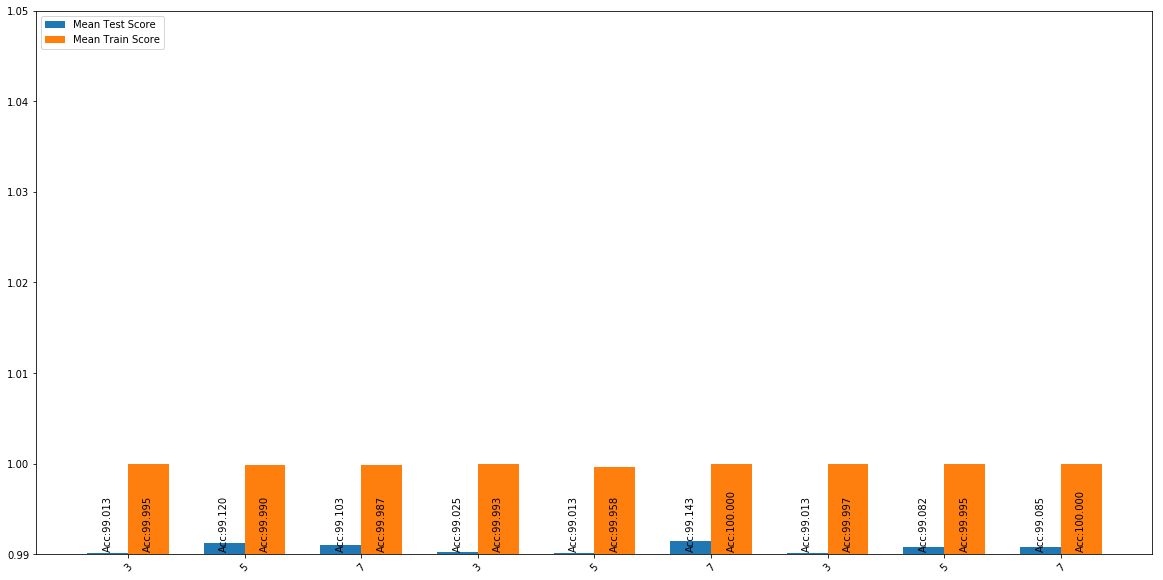

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

Significant improvement can be seen using increasing kernels: This is because small kernels are taking care of smaller details while bigger kernels are looking at larger pictures of features.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 358us/step - loss: 0.1561 - acc: 0.9519 - val_loss: 0.0460 - val_acc: 0.9851
Epoch 2/20
60000/60000 [==============================] - 17s 278us/step - loss: 0.0560 - acc: 0.9830 - val_loss: 0.0308 - val_acc: 0.9906
Epoch 3/20
60000/60000 [==============================] - 16s 275us/step - loss: 0.0433 - acc: 0.9870 - val_loss: 0.0319 - val_acc: 0.9888
Epoch 4/20
60000/60000 [==============================] - 16s 271us/step - loss: 0.0351 - acc: 0.9895 - val_loss: 0.0257 - val_acc: 0.9915
Epoch 5/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.0301 - acc: 0.9903 - val_loss: 0.0247 - val_acc: 0.9916
Epoch 6/20
60000/60000 [==============================] - 16s 269us/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0242 - val_acc: 0.9925
Epoch 7/20
60000/60000 [==============================] - 16s 269us/step - loss: 0.0220 - acc: 0.9932 - val_loss: 0.

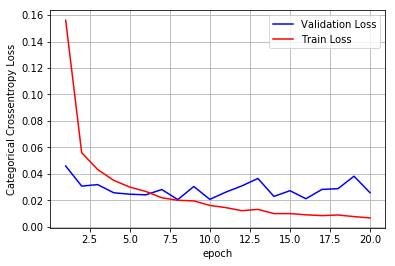

In [0]:
# Best model
model= conv_model_varying_kernel(7)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 4 : Hyperparameter tuning with 5 layers, batch normalization and varying kernels, applying cross validation and comparing results

In [0]:
# Adding batch normalization to the model
def conv_model_varying_kernel(kernel_n):
  Model_4 = Sequential()
  #Layer 1 [ReLU]
  Model_4.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape, padding='same'))
  Model_4.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_4.add(Conv2D(64, (kernel_n+2, kernel_n+2), activation='relu', padding='same'))
  Model_4.add(BatchNormalization())
  Model_4.add(MaxPooling2D(pool_size=(2, 2)))
  Model_4.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_4.add(Conv2D(128, (kernel_n+4, kernel_n+4), activation='relu', padding='same'))
  Model_4.add(BatchNormalization())
  Model_4.add(MaxPooling2D(pool_size=(2, 2)))
  Model_4.add(Dropout(0.25))

  #Layer 4 [ReLU]
  Model_4.add(Flatten())
  Model_4.add(Dense(256, activation='relu'))
  Model_4.add(BatchNormalization())
  Model_4.add(Dropout(0.5))

  #Layer 5 [Softmax]
  Model_4.add(Dense(num_classes, activation='softmax'))

  Model_4.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_4


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5, 7]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_varyingkernel= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 115.7min finished


In [0]:
print(input_shape)

(28, 28, 1)


In [0]:
print("Best: %f using %s" % (grid_result_varyingkernel.best_score_, grid_result_varyingkernel.best_params_))
print("Best estimator: ", grid_result_varyingkernel.best_estimator_)

means_test = grid_result_varyingkernel.cv_results_['mean_test_score']
means_train = grid_result_varyingkernel.cv_results_['mean_train_score']
stds_test = grid_result_varyingkernel.cv_results_['std_test_score']
stds_train = grid_result_varyingkernel.cv_results_['std_train_score']
params = grid_result_varyingkernel.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.993567 using {'batch_size': 32, 'kernel_n': 7}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5906d55b00>
0.992533 0.999900 (0.000067) with: {'batch_size': 32, 'kernel_n': 3}
0.993417 0.999967 (0.000317) with: {'batch_size': 32, 'kernel_n': 5}
0.993567 0.999983 (0.000100) with: {'batch_size': 32, 'kernel_n': 7}
0.992317 0.999967 (0.000217) with: {'batch_size': 64, 'kernel_n': 3}
0.992967 0.999833 (0.000667) with: {'batch_size': 64, 'kernel_n': 5}
0.992950 0.999967 (0.000483) with: {'batch_size': 64, 'kernel_n': 7}
0.992150 0.999967 (0.000283) with: {'batch_size': 128, 'kernel_n': 3}
0.992683 0.999900 (0.000617) with: {'batch_size': 128, 'kernel_n': 5}
0.992783 0.999950 (0.000083) with: {'batch_size': 128, 'kernel_n': 7}


In [0]:
import pickle
with open('grid_result__5layer_varyingkernel.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingkernel.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result__5layer_varyingkernel.pickle drive/My\ Drive/CNN_models/

cp: cannot create regular file 'drive/My Drive/CNN_models/': No such file or directory


9


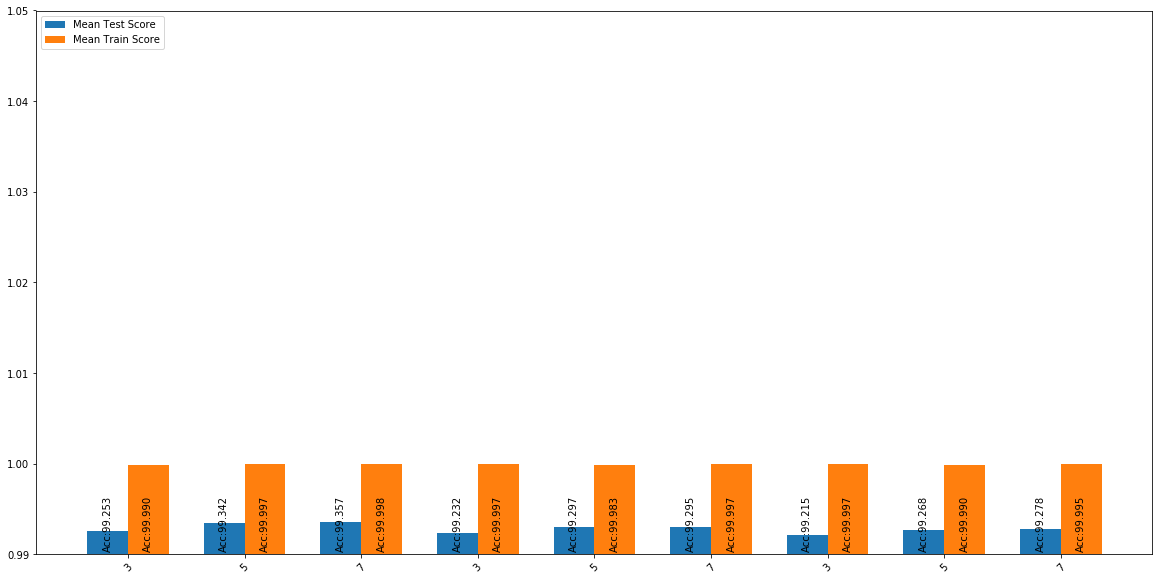

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')


I can see all my models above 99% mark also best accuracy is 99.347 which is also better than before


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.1233 - acc: 0.9626 - val_loss: 0.0346 - val_acc: 0.9878
Epoch 2/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0575 - acc: 0.9820 - val_loss: 0.0194 - val_acc: 0.9941
Epoch 3/20
60000/60000 [==============================] - 60s 996us/step - loss: 0.0453 - acc: 0.9864 - val_loss: 0.0273 - val_acc: 0.9911
Epoch 4/20
60000/60000 [==============================] - 60s 996us/step - loss: 0.0376 - acc: 0.9889 - val_loss: 0.0232 - val_acc: 0.9922
Epoch 5/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0319 - acc: 0.9903 - val_loss: 0.0228 - val_acc: 0.9927
Epoch 6/20
60000/60000 [==============================] - 60s 995us/step - loss: 0.0261 - acc: 0.9915 - val_loss: 0.0168 - val_acc: 0.9951
Epoch 7/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0235 - acc: 0.9930 - val_loss: 0.0211 - v

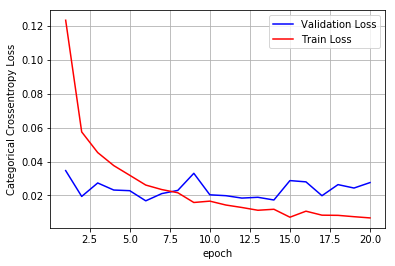

In [0]:
# Best model
model= conv_model_varying_kernel(5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 5 : Hyperparameter tuning with varying kernels with same number of filters and then increasing filter size, applying cross validation and comparing results

In [0]:
# Adding batch normalization to the model
def conv_model_varying_kernel_with_same_filter(kernel_n):
  Model_5 = Sequential()

  #Layer 1 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape, padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 2 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))


  #Layer 4 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 5 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 6 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))


  #Layer 7 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 8 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 9 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 10 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 11 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 12 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))
  
  Model_5.add(Flatten())

  #Layer 13 [Softmax]
  Model_5.add(Dense(10, activation='softmax'))

  Model_5.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  
  return Model_5


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel_with_same_filter, epochs=20, verbose=0)

batch = [32, 64]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 10)
grid_result_varyingKernelFixedFilters= grid.fit(x_train, y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=32, kernel_n=3, score=(train=0.999, test=0.993), total=23.9min
[CV] batch_size=32, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.2min remaining:    0.0s


[CV]  batch_size=32, kernel_n=3, score=(train=0.999, test=0.993), total=24.4min
[CV] batch_size=32, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 48.8min remaining:    0.0s


[CV]  batch_size=32, kernel_n=5, score=(train=0.999, test=0.993), total=28.8min
[CV] batch_size=32, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 78.0min remaining:    0.0s


[CV]  batch_size=32, kernel_n=5, score=(train=0.999, test=0.993), total=29.0min
[CV] batch_size=64, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 107.3min remaining:    0.0s


[CV]  batch_size=64, kernel_n=3, score=(train=0.999, test=0.993), total=16.2min
[CV] batch_size=64, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 123.7min remaining:    0.0s


[CV]  batch_size=64, kernel_n=3, score=(train=0.999, test=0.993), total=16.2min
[CV] batch_size=64, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 140.1min remaining:    0.0s


[CV]  batch_size=64, kernel_n=5, score=(train=0.998, test=0.991), total=19.4min
[CV] batch_size=64, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 159.8min remaining:    0.0s


[CV]  batch_size=64, kernel_n=5, score=(train=0.999, test=0.992), total=19.5min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 179.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 179.5min finished


In [0]:
print("Best: %f using %s" % (grid_result_varyingKernelFixedFilters.best_score_, grid_result_varyingKernelFixedFilters.best_params_))
print("Best estimator: ", grid_result_varyingKernelFixedFilters.best_estimator_)

means_test = grid_result_varyingKernelFixedFilters.cv_results_['mean_test_score']
means_train = grid_result_varyingKernelFixedFilters.cv_results_['mean_train_score']
stds_test = grid_result_varyingKernelFixedFilters.cv_results_['std_test_score']
stds_train = grid_result_varyingKernelFixedFilters.cv_results_['std_train_score']
params = grid_result_varyingKernelFixedFilters.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.993317 using {'batch_size': 32, 'kernel_n': 3}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5aa98f12e8>
0.993317 0.999083 (0.000017) with: {'batch_size': 32, 'kernel_n': 3}
0.992967 0.999100 (0.000200) with: {'batch_size': 32, 'kernel_n': 5}
0.992667 0.998983 (0.000167) with: {'batch_size': 64, 'kernel_n': 3}
0.991917 0.998467 (0.000483) with: {'batch_size': 64, 'kernel_n': 5}


In [0]:
import pickle
with open('grid_result_varyingKernelFixedFilters.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingKernelFixedFilters.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_varyingKernelFixedFilters.pickle drive/My\ Drive/CNN_models/

4


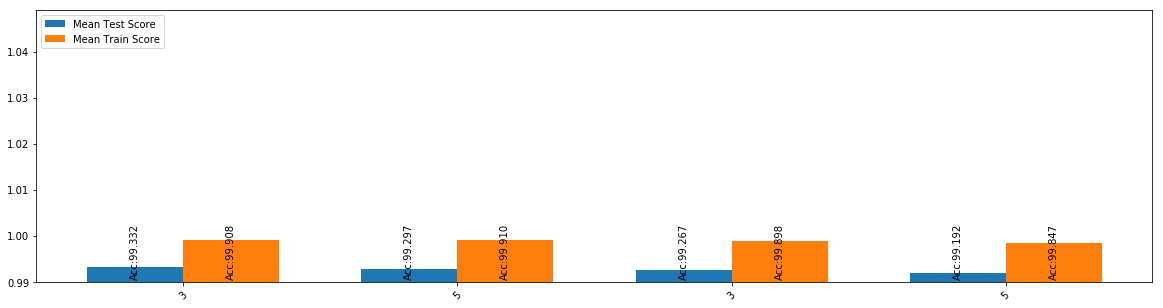

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 160s 3ms/step - loss: 0.2779 - acc: 0.9179 - val_loss: 0.0789 - val_acc: 0.9791
Epoch 2/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0858 - acc: 0.9768 - val_loss: 0.0489 - val_acc: 0.9862
Epoch 3/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0682 - acc: 0.9808 - val_loss: 0.0345 - val_acc: 0.9903
Epoch 4/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0594 - acc: 0.9838 - val_loss: 0.0303 - val_acc: 0.9913
Epoch 5/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0495 - acc: 0.9859 - val_loss: 0.0374 - val_acc: 0.9903
Epoch 6/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0425 - acc: 0.9879 - val_loss: 0.0314 - val_acc: 0.9916
Epoch 7/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0389 - acc: 0.9889 - val_loss: 0.0425 - 

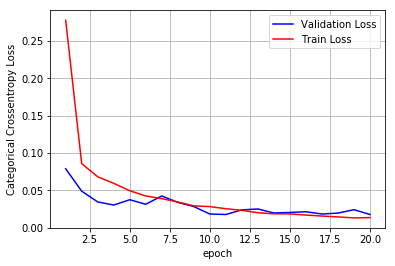

In [0]:
# best model

model= conv_model_varying_kernel_with_same_filter(3)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

{'batch_size': 32, 'kernel_n': 3}


## Comparision

### Comparision: 
Here are few suggestions:

1. Can you please experiment with BN layer, without BN Layer, different activations, optimzers, weight initializations and architectures, different dropouts etc?
2. Write a conclusion section at the end explaining what you did in this assignment.
3. Keep your earlier models, and experiment with new ones.

#### Without Batch Normalization

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s 401us/step - loss: 0.1989 - acc: 0.9395 - val_loss: 0.0599 - val_acc: 0.9811
Epoch 2/20
60000/60000 [==============================] - 23s 387us/step - loss: 0.0817 - acc: 0.9757 - val_loss: 0.0457 - val_acc: 0.9849
Epoch 3/20
60000/60000 [==============================] - 23s 383us/step - loss: 0.0696 - acc: 0.9799 - val_loss: 0.0424 - val_acc: 0.9872
Epoch 4/20
60000/60000 [==============================] - 23s 381us/step - loss: 0.0620 - acc: 0.9818 - val_loss: 0.0384 - val_acc: 0.9883
Epoch 5/20
60000/60000 [==============================] - 23s 379us/step - loss: 0.0612 - acc: 0.9819 - val_loss: 0.0358 - val_acc: 0.9890
Epoch 6/20
60000/60000 [==============================] - 23s 380us/step - loss: 0.0592 - acc: 0.9829 - val_loss: 0.0397 - val_acc: 0.9892
Epoch 7/20
60000/60000 [==============================] - 23s 381us/step - loss: 0.0569 - acc: 0.9841 - val_loss: 0.

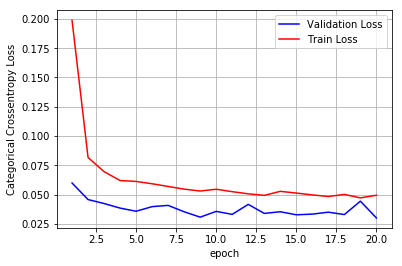

In [0]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))

m.add(Dropout(0.25))
m.add(Conv2D(64, kernel, activation='relu'))

m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

#### With Batch Normalization

W0820 14:01:50.105624 140517998344064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 29s 481us/step - loss: 0.3511 - acc: 0.9081 - val_loss: 0.0783 - val_acc: 0.9795
Epoch 2/20
60000/60000 [==============================] - 27s 454us/step - loss: 0.1606 - acc: 0.9626 - val_loss: 0.0475 - val_acc: 0.9862
Epoch 3/20
60000/60000 [==============================] - 27s 453us/step - loss: 0.1252 - acc: 0.9686 - val_loss: 0.0531 - val_acc: 0.9855
Epoch 4/20
60000/60000 [==============================] - 27s 452us/step - loss: 0.1067 - acc: 0.9735 - val_loss: 0.0453 - val_acc: 0.9865
Epoch 5/20
60000/60000 [==============================] - 27s 449us/step - loss: 0.0962 - acc: 0.9757 - val_loss: 0.0407 - val_acc: 0.9868
Epoch 6/20
60000/60000 [==============================] - 27s 452us/step - loss: 0.0799 - acc: 0.9798 - val_loss: 0.0546 - val_acc: 0.9839
Epoch 7/20
60000/60000 [==============================] - 27s 450us/step - loss: 0.0781 - acc: 0.9795 - val_loss: 0.

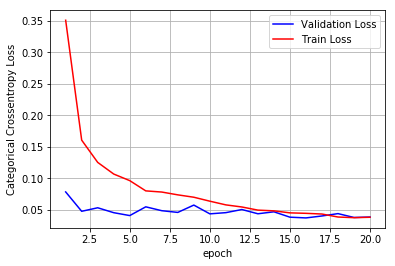

In [0]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With tanh activation functions

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 28s 465us/step - loss: 0.3498 - acc: 0.8934 - val_loss: 0.0830 - val_acc: 0.9736
Epoch 2/20
60000/60000 [==============================] - 26s 441us/step - loss: 0.1065 - acc: 0.9684 - val_loss: 0.0577 - val_acc: 0.9825
Epoch 3/20
60000/60000 [==============================] - 27s 442us/step - loss: 0.0820 - acc: 0.9763 - val_loss: 0.0484 - val_acc: 0.9856
Epoch 4/20
60000/60000 [==============================] - 26s 440us/step - loss: 0.0689 - acc: 0.9795 - val_loss: 0.0460 - val_acc: 0.9838
Epoch 5/20
60000/60000 [==============================] - 26s 440us/step - loss: 0.0619 - acc: 0.9814 - val_loss: 0.0381 - val_acc: 0.9872
Epoch 6/20
60000/60000 [==============================] - 27s 443us/step - loss: 0.0555 - acc: 0.9829 - val_loss: 0.0402 - val_acc: 0.9871
Epoch 7/20
60000/60000 [==============================] - 27s 443us/step - loss: 0.0510 - acc: 0.9842 - val_loss: 0.

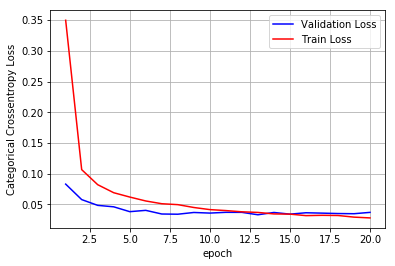

In [11]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='tanh', kernel_initializer= initializers.glorot_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='tanh'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='tanh'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With sigmoid activation functions

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 30s 500us/step - loss: 0.2576 - acc: 0.9268 - val_loss: 0.0720 - val_acc: 0.9784
Epoch 2/20
60000/60000 [==============================] - 28s 472us/step - loss: 0.0941 - acc: 0.9724 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 3/20
60000/60000 [==============================] - 28s 471us/step - loss: 0.0761 - acc: 0.9782 - val_loss: 0.0508 - val_acc: 0.9836
Epoch 4/20
60000/60000 [==============================] - 27s 456us/step - loss: 0.0654 - acc: 0.9804 - val_loss: 0.0407 - val_acc: 0.9868
Epoch 5/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0600 - acc: 0.9821 - val_loss: 0.0392 - val_acc: 0.9869
Epoch 6/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0578 - acc: 0.9835 - val_loss: 0.0424 - val_acc: 0.9863
Epoch 7/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0518 - acc: 0.9849 - val_loss: 0.

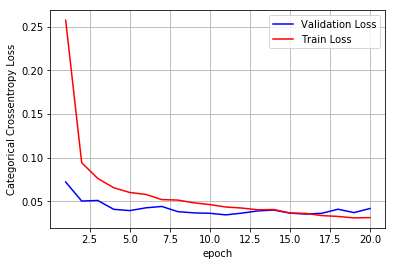

In [12]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='sigmoid', kernel_initializer= initializers.glorot_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='sigmoid'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='sigmoid'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With adagrad optimizer

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s 406us/step - loss: 0.5568 - acc: 0.8872 - val_loss: 0.0984 - val_acc: 0.9760
Epoch 2/20
60000/60000 [==============================] - 23s 386us/step - loss: 0.1623 - acc: 0.9532 - val_loss: 0.0701 - val_acc: 0.9818
Epoch 3/20
60000/60000 [==============================] - 23s 384us/step - loss: 0.1245 - acc: 0.9637 - val_loss: 0.0564 - val_acc: 0.9861
Epoch 4/20
60000/60000 [==============================] - 23s 387us/step - loss: 0.0988 - acc: 0.9712 - val_loss: 0.0638 - val_acc: 0.9851
Epoch 5/20
60000/60000 [==============================] - 23s 383us/step - loss: 0.0884 - acc: 0.9738 - val_loss: 0.0472 - val_acc: 0.9870
Epoch 6/20
60000/60000 [==============================] - 23s 383us/step - loss: 0.0807 - acc: 0.9760 - val_loss: 0.0482 - val_acc: 0.9869
Epoch 7/20
60000/60000 [==============================] - 23s 383us/step - loss: 0.0705 - acc: 0.9788 - val_loss: 0.

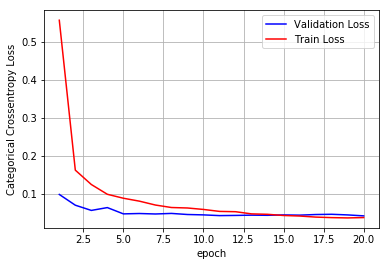

In [13]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adagrad(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With rmsprop optimizer

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 26s 430us/step - loss: 0.4629 - acc: 0.9047 - val_loss: 0.1034 - val_acc: 0.9777
Epoch 2/20
60000/60000 [==============================] - 24s 402us/step - loss: 0.2328 - acc: 0.9555 - val_loss: 0.0997 - val_acc: 0.9796
Epoch 3/20
60000/60000 [==============================] - 24s 401us/step - loss: 0.1941 - acc: 0.9637 - val_loss: 0.1186 - val_acc: 0.9804
Epoch 4/20
60000/60000 [==============================] - 24s 399us/step - loss: 0.1720 - acc: 0.9665 - val_loss: 0.1022 - val_acc: 0.9798
Epoch 5/20
60000/60000 [==============================] - 24s 397us/step - loss: 0.1494 - acc: 0.9692 - val_loss: 0.0672 - val_acc: 0.9858
Epoch 6/20
60000/60000 [==============================] - 24s 394us/step - loss: 0.1302 - acc: 0.9728 - val_loss: 0.0505 - val_acc: 0.9867
Epoch 7/20
60000/60000 [==============================] - 24s 393us/step - loss: 0.1201 - acc: 0.9746 - val_loss: 0.

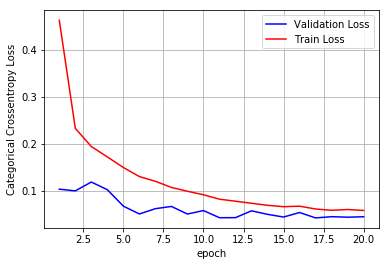

In [14]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.RMSprop(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With sgd optimizer

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s 399us/step - loss: 0.3255 - acc: 0.9020 - val_loss: 0.0740 - val_acc: 0.9777
Epoch 2/20
60000/60000 [==============================] - 23s 377us/step - loss: 0.1418 - acc: 0.9570 - val_loss: 0.0495 - val_acc: 0.9833
Epoch 3/20
60000/60000 [==============================] - 23s 377us/step - loss: 0.1110 - acc: 0.9670 - val_loss: 0.0448 - val_acc: 0.9854
Epoch 4/20
60000/60000 [==============================] - 23s 378us/step - loss: 0.0918 - acc: 0.9729 - val_loss: 0.0399 - val_acc: 0.9875
Epoch 5/20
60000/60000 [==============================] - 23s 375us/step - loss: 0.0819 - acc: 0.9757 - val_loss: 0.0325 - val_acc: 0.9888
Epoch 6/20
60000/60000 [==============================] - 22s 375us/step - loss: 0.0725 - acc: 0.9782 - val_loss: 0.0352 - val_acc: 0.9887
Epoch 7/20
60000/60000 [==============================] - 22s 374us/step - loss: 0.0652 - acc: 0.9797 - val_loss: 0.

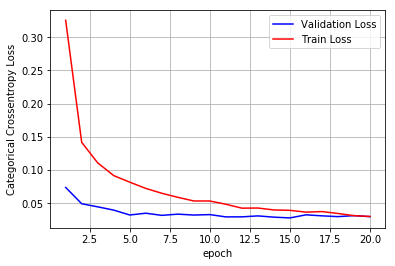

In [15]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.SGD(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With adadelta optimizer

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 29s 480us/step - loss: 0.3387 - acc: 0.9107 - val_loss: 0.0840 - val_acc: 0.9775
Epoch 2/20
60000/60000 [==============================] - 27s 449us/step - loss: 0.1472 - acc: 0.9651 - val_loss: 0.0599 - val_acc: 0.9843
Epoch 3/20
60000/60000 [==============================] - 27s 445us/step - loss: 0.1202 - acc: 0.9708 - val_loss: 0.0569 - val_acc: 0.9844
Epoch 4/20
60000/60000 [==============================] - 27s 445us/step - loss: 0.1001 - acc: 0.9751 - val_loss: 0.0472 - val_acc: 0.9876
Epoch 5/20
60000/60000 [==============================] - 27s 444us/step - loss: 0.0861 - acc: 0.9786 - val_loss: 0.0538 - val_acc: 0.9843
Epoch 6/20
60000/60000 [==============================] - 27s 446us/step - loss: 0.0863 - acc: 0.9783 - val_loss: 0.0477 - val_acc: 0.9873
Epoch 7/20
60000/60000 [==============================] - 27s 446us/step - loss: 0.0762 - acc: 0.9807 - val_loss: 0.

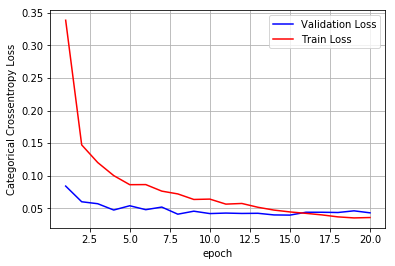

In [16]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### With adam optimizer

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 29s 486us/step - loss: 0.3844 - acc: 0.8910 - val_loss: 0.0867 - val_acc: 0.9778
Epoch 2/20
60000/60000 [==============================] - 27s 449us/step - loss: 0.1776 - acc: 0.9506 - val_loss: 0.0730 - val_acc: 0.9821
Epoch 3/20
60000/60000 [==============================] - 27s 447us/step - loss: 0.1386 - acc: 0.9620 - val_loss: 0.0560 - val_acc: 0.9854
Epoch 4/20
60000/60000 [==============================] - 27s 445us/step - loss: 0.1161 - acc: 0.9670 - val_loss: 0.0518 - val_acc: 0.9856
Epoch 5/20
60000/60000 [==============================] - 26s 439us/step - loss: 0.1043 - acc: 0.9711 - val_loss: 0.0604 - val_acc: 0.9850
Epoch 6/20
60000/60000 [==============================] - 26s 439us/step - loss: 0.0876 - acc: 0.9752 - val_loss: 0.0464 - val_acc: 0.9868
Epoch 7/20
60000/60000 [==============================] - 26s 440us/step - loss: 0.0788 - acc: 0.9779 - val_loss: 0.

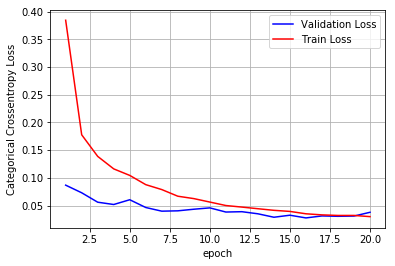

In [17]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam
from keras import initializers

kernel= (3, 3)
# Initializing a sequential model
m= Sequential()
m.add(Conv2D(32, kernel_size=kernel,
                activation='relu', kernel_initializer= initializers.he_normal(seed=None),
                input_shape=input_shape))
m.add(BatchNormalization())
m.add(Dropout(0.25))

m.add(Conv2D(64, kernel, activation='relu'))
m.add(BatchNormalization())
m.add(MaxPooling2D(pool_size=(2, 2)))
m.add(Dropout(0.25))

m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dropout(0.5))

m.add(Dense(num_classes, activation='softmax'))

m.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

history = m.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = m.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


#### Comparing results

without batch normalization accuracy= 99.17
with batch normalization accuracy=  99.26 with smother epoch loss curve means less overfitting than without batch normalization

with tanh activation func and xavior/glorot initializer accuracy= 98.91
not that drastic reduction in validation loss as with relu activation function because weights are distributed within all output layers whereas with relu activation function output layer weights are less distributed amongs all layers

with sigmoid activation function accuracy= 98.84 better results than tanh
not that drastic reduction in validation loss as with relu activation function 
Comparing Optimizers:

With adagrad optimizer accuracy= 99.09

With RMSprop optimizeraccuracy= 98.8

With SGD optmizer accuracy= 99.21

With Adadelta optimizer accuracy= 99.11

With Adam optimizer accuracy= 99.01


In [0]:
from prettytable import PrettyTable
print('Accuracy comparision')

x= PrettyTable(['Model', 'Batch_size', 'Validation Score', 'Observation'])
x.add_row(['Model 1', '64', '99.33', 'This is the simplest model with same kernel values, best kernel being (7x7)'])
x.add_row(['Model 2', '32', '99.44', 'This is a 3 layer model with same kernel size, best hyperparameter is (7x7) kernel size and batch size= 32'])
x.add_row(['Model 3', '64', '99.34', 'This is a 3 layer model followed by a dense layer,we have varied kernel size with layers in this model, this model is also starting to overfit'])
x.add_row(['Model 4', '32', '99.35', 'The model is starting to overfit looking at loss vs epochs curve'])
x.add_row(['Model 5', '32', '99.5', 'This seems like the best model among all, I have mixed together kernels with layers and dropouts, also the model is not overfitting'])
x.align= 'l'
print(x)

Accuracy comparision
+---------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------+
| Model   | Batch_size | Validation Score | Observation                                                                                                                                    |
+---------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------+
| Model 1 | 64         | 99.33            | This is the simplest model with same kernel values, best kernel being (7x7)                                                                    |
| Model 2 | 32         | 99.44            | This is a 3 layer model with same kernel size, best hyperparameter is (7x7) kernel size and batch size= 32                                     |
| Model 3 | 64         | 99.34    

In [21]:
from prettytable import PrettyTable
print('Comparing batch normalization')
x= PrettyTable(['Model', 'Kernel Size', 'Batch_size', 'Dropouts', 'Activation', 'Initializer', 'Optimizer', 'Score', 'Observation'])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 without batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adam', '99.17', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adam', '99.26', 'With Batchnormalization it can be observed from loss v epochs graph that the loss curve is less fluctuating with batch normalization of layers'])
print(x)

x= PrettyTable(['Model', 'Kernel Size', 'Batch_size', 'Dropouts', 'Activation', 'Initializer', 'Optimizer', 'Score', 'Observation'])
print('Comparing Activation functions')
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['tanh, tanh, softmax'], 'glorot-normal', 'adam', '98.91', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['sigmoid, sigmoid, softmax'], 'glorot-normal', 'adam', '98.84', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adam', '99.26', 'Accuracy is best with relu activation and weights are distributed among less output layer making it more generalized in nature'])
print(x)

x= PrettyTable(['Neurons', 'Kernel Size', 'Batch_size', 'Dropouts', 'Activation', 'Initializer', 'Optimizer', 'Score', 'Observation'])
print('Comparing Optimizers')
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adagrad', '99.09', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'rmsprop', '98.8', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'SGD', '99.21', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adadelta', '99.11', ''])
x.add_row(['[32, 64, 128, 10]', '(3 x 3)', '32 with batch normalization', '[0.5, 0.2]', ['relu, relu, softmax'], 'he-normal', 'adam', '99.01', 'Adadelta optimizer gives best result among all optimizer in this case'])
print(x)


Comparing batch normalization
+-------------------+-------------+--------------------------------+------------+-------------------------+-------------+-----------+-------+------------------------------------------------------------------------------------------------------------------------------------------------+
|       Model       | Kernel Size |           Batch_size           |  Dropouts  |        Activation       | Initializer | Optimizer | Score |                                                                  Observation                                                                   |
+-------------------+-------------+--------------------------------+------------+-------------------------+-------------+-----------+-------+------------------------------------------------------------------------------------------------------------------------------------------------+
| [32, 64, 128, 10] |   (3 x 3)   | 32 without batch normalization | [0.5, 0.2] | ['relu, relu, softmax'] |  

### Assignment accomplishments



1.   Started with basic Convolution neural network with same kernel size of (3, 3) maxpooling of (2, 2 ) and dropout of 0.25 and 0.5 on hidden layers respectively
2.   Hyper-parameter tuning of 4 layer CNN with batch sizes 32, 64, 128 and kernel size (3,3), (5,5), (7,7) and plotted train and test results using bar graph
3.   Tried out varying kernel based model and hyper parameter tuned it. every layer had a different kernel filter.
4.   Tried out 5 layer CNN and applyied hyper parameter tuning on batch size and kernel size as before
5.   For each best model, plotted an epoch vs loss curve ti check whether the model is overfitting.
6.   Tried out a mixture of varying kernel and varying layer size in the 5th model.
7.   Experimented with batch normalization, optimizers, weight initializers and dropouts
8.   Observed that batch normalization is reducing validation loss curve fluctuations hence less chances of overfitting. Tried out activation funtions like relu, sigmoid and tanh followed by softmax activation, observed that relu is significantly quicker in reducing loss than others.
9.   Added dropout layers to reduce overfitting of any model.

